# Differential Expression Analysis

The differential expression analysis aims at identifying the genes whose expression levels change between two sample groups. For the differential expression (DE) analysis, we use R package Limma as part of a customised expression pipeline.

At this point, expression and clinical datasets are expected to be clean/preprocessed, containing the same samples and in the same order and ready to use in limma. Do a previous preprocessing if needed.

### Read clinical and expression datasets. GSE15222

In [1]:
datasets=load("/mnt/data/GWES/Microarray/output/GSE15222/objects.RData")
datasets

[1] "expr.log.complete" "clinicalset"

In [2]:
dim(clinicalset)
head(clinicalset)

[1] 336   5

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM388327,Female,85,Case,34,Group4
GSM388385,Male,77,Case,34,Group4
GSM388383,Female,90,Case,44,Group4
GSM388302,Male,73,Case,33,Group3
GSM388303,Female,89,Case,44,Group4
GSM388285,Male,86,Case,33,Group3


In [3]:
dim(expr.log.complete)
head(expr.log.complete,n=3L)

[1] 9592  363

,GSM225652,GSM225662,GSM225664,GSM225665,GSM225666,GSM225667,GSM225668,GSM225669,GSM225670,GSM225671,...,GSM388388,GSM388389,GSM388390,GSM388391,GSM388392,GSM388393,GSM388394,GSM388395,GSM388396,GSM388397
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.394077,12.374868,12.443017,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.577844,6.751791,6.971065,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,10.398109,9.862523,10.392574,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


**Note: It is very important that clinical and expression datasets have the same samples and maintain the same order. Check for this if working with the two dataset separated, or merge them and work with the merged dataframe.** rownames(clinicalset) or sample name/ID column must be in the same order as colnames(expressionset)

***or use ReadAffy in the previous step and start this tutorial with a single dataset.**

In [4]:
# keep the expression values for those samples in the clinical dataset
expression=expr.log.complete[, rownames(clinicalset)]
dim(expression)

[1] 9592  336

In [5]:
table(colnames(expression) == rownames(clinicalset))


TRUE 
 336 

**Suggested function to keep the same samples in both datasets and in the same order.** It is very useful for heatmaps to create rownames in the expressionset as a combination of conditions from the clinicalset.

In [7]:
# Keep the same samples in both datasets and in the same order
# 1st param: clinical dataframe
# 2nd param: expression dataframe
# returns a list containing the new clinicalset as first element and new expression set as the second element
# optional: create rownames in expressionset as a combination of conditions from clinicalset. Very useful for heatmaps in DE
keepCommonSamplesDF_function<-function(clinicalset,expression.df){  
    merged.df=merge(t(expression.df),clinicalset,by= "row.names")
    # optional - customise
    rownames(merged.df)<-paste(merged.df$Row.names,merged.df$Status,merged.df$APOEgroup,sep="_")
    ncols<-ncol(merged.df)-ncol(clinicalset) # remove columns from clinical data, bear in mind the clinical.match column
    new.expr<-t(merged.df[, 2:ncols] ) # 1st column is Row.names that merge command creates
    from=ncols+1
    to=dim(merged.df)[2]
    new.clinicalset<-merged.df[, from:to]
    return(list(new.clinicalset,new.expr))
}

In [8]:
# call keepCommonSamplesDF function to get clinical and expression sets containing matching samples
sets=keepCommonSamplesDF_function(clinicalset,expr.log.complete) 
clinicalset.common=sets[[1]]
dim(clinicalset.common)
expr.common=sets[[2]]
dim(expr.common)

[1] 336   5

[1] 9592  336

Check that the datasets are correct and keepCommonSamplesDF function fits your needs.

In [9]:
head(clinicalset.common,n=3)
head(expr.common,n=3)

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM225652__Group3,Male,85,Control,33,Group3
GSM225662__Group3,Male,85,Control,33,Group3
GSM225664__Group3,Male,79,Control,33,Group3


,GSM225652__Group3,GSM225662__Group3,GSM225664__Group3,GSM225665__Group3,GSM225666__Group3,GSM225667__Group3,GSM225668__Group3,GSM225670__Group4,GSM225671__Group3,GSM225672__Group3,...,GSM388388__Group4,GSM388389__Group3,GSM388390__Group2,GSM388391__Group4,GSM388392__Group3,GSM388393__Group4,GSM388394__Group4,GSM388395__Group4,GSM388396__Group4,GSM388397__Group4
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.374868,12.443017,11.133454,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.751791,6.971065,5.909498,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,9.862523,10.392574,10.088680,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


### Differential Expression with Limma

Limma is  a  package  for  the  analysis  of  gene  expression  data  arising  from  microarray  or  RNA-seq technologies

In [10]:
# Import differential expression functions to use the customised anotation function
source("scripts/diffExpressionPipeline.R")

#### prepare limma sets with covariates

In [35]:
model.matrix=model.matrix(~0+diagnosis+age+sex,data = clinicalset.common)
colnames(model.matrix)=c("case","control","age","sexMale")
head(model.matrix)

,case,control,age,sexMale
GSM225652__Group3,0,1,85,1
GSM225662__Group3,0,1,85,1
GSM225664__Group3,0,1,79,1
GSM225665__Group3,0,1,85,0
GSM225666__Group3,0,1,73,0
GSM225667__Group3,0,1,81,1


In [36]:
#design.matrix <- sapply(design_matrix, as.numeric)
contrast.matrix.cov <- makeContrasts(case - control, levels = model.matrix)
set.seed(1)
head(contrast.matrix.cov)

,case - control
case,1
control,-1
age,0
sexMale,0


In [37]:
# This code fits the linear model, smooths the standard errors and displays the top 10 genes for case versus control comparison.
fit.cov <- lmFit(expr.common, model.matrix)
fit.cov <- contrasts.fit(fit.cov, contrast.matrix.cov)
fit.cov <- eBayes(fit.cov)
    
toplist.cov=topTable(fit.cov,sort.by="P",confint=TRUE)
toplist.cov

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GI_4585642-S,0.9927010,0.8431380,1.1422639,6.968506,13.05592,8.439873e-32,7.130849e-28,61.36442
GI_34577121-S,0.5218817,0.4335437,0.6102196,8.770397,11.62084,1.785482e-26,7.542768e-23,49.34172
GI_37547175-S,0.4570696,0.3784023,0.5357368,8.529392,11.42882,8.829622e-26,2.486716e-22,47.77492
GI_24308166-S,-0.7629922,-0.8947244,-0.6312600,9.870840,-11.39308,1.187431e-25,2.508151e-22,47.48454
GI_13376557-S,1.0146079,0.8349594,1.1942564,6.603658,11.10932,1.229898e-24,2.078281e-21,45.19341
GI_27734844-S,-0.6927129,-0.8162635,-0.5691624,8.106616,-11.02863,2.379554e-24,3.350808e-21,44.54666
GI_44917603-S,0.9805156,0.8049119,1.1561192,6.759882,10.98333,3.443547e-24,4.156361e-21,44.18450
GI_30089918-A,0.3868948,0.3165662,0.4572234,8.018805,10.82116,1.285516e-23,1.280157e-20,42.89382
GI_7706261-S,-0.8036949,-0.9498867,-0.6575031,8.737656,-10.81387,1.363643e-23,1.280157e-20,42.83601


In [38]:
# DE summary
summary(decideTests(fit.cov))

       case - control
Down             2239
NotSig           3048
Up               3162

In [39]:
alltable.cov=topTable(fit.cov,sort.by="P",n=Inf,confint=TRUE)
write.table(alltable.cov,"/mnt/data/GWES/output/GSE15222/limma_covariates_results")

#### Annotate limma result

Translate probes to gene symbols using the custom annotate_function.

In [40]:
# call annotate_function to translate probeIDs to gene IDs
alltable.annot<-annotate_function(alltable.cov,platform = "2700")
write.table(alltable.annot,"/mnt/data/GWES/output/GSE15222/limma_cov_results_annot")
head(alltable.annot,n=10)


 dim alltable annotated  7553 11 


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,platform,gene_id,organism
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
ZNF264,0.9927010,0.8431380,1.1422639,6.968506,13.05592,8.439873e-32,7.130849e-28,61.36442,GPL2700,9422,Homo sapiens
NFKB1,0.5218817,0.4335437,0.6102196,8.770397,11.62084,1.785482e-26,7.542768e-23,49.34172,GPL2700,4790,Homo sapiens
DSTYK,0.4570696,0.3784023,0.5357368,8.529392,11.42882,8.829622e-26,2.486716e-22,47.77492,GPL2700,25778,Homo sapiens
SVOP,-0.7629922,-0.8947244,-0.6312600,9.870840,-11.39308,1.187431e-25,2.508151e-22,47.48454,GPL2700,55530,Homo sapiens
ZDHHC23,-0.6927129,-0.8162635,-0.5691624,8.106616,-11.02863,2.379554e-24,3.350808e-21,44.54666,GPL2700,254887,Homo sapiens
SRGAP1,0.9805156,0.8049119,1.1561192,6.759882,10.98333,3.443547e-24,4.156361e-21,44.18450,GPL2700,57522,Homo sapiens
POLDIP3,0.3868948,0.3165662,0.4572234,8.018805,10.82116,1.285516e-23,1.280157e-20,42.89382,GPL2700,84271,Homo sapiens
ATP6V1H,-0.8036949,-0.9498867,-0.6575031,8.737656,-10.81387,1.363643e-23,1.280157e-20,42.83601,GPL2700,51606,Homo sapiens
SLC35E1,0.7205301,0.5878030,0.8532573,7.911680,10.67838,4.068711e-23,3.437654e-20,41.76502,GPL2700,79939,Homo sapiens


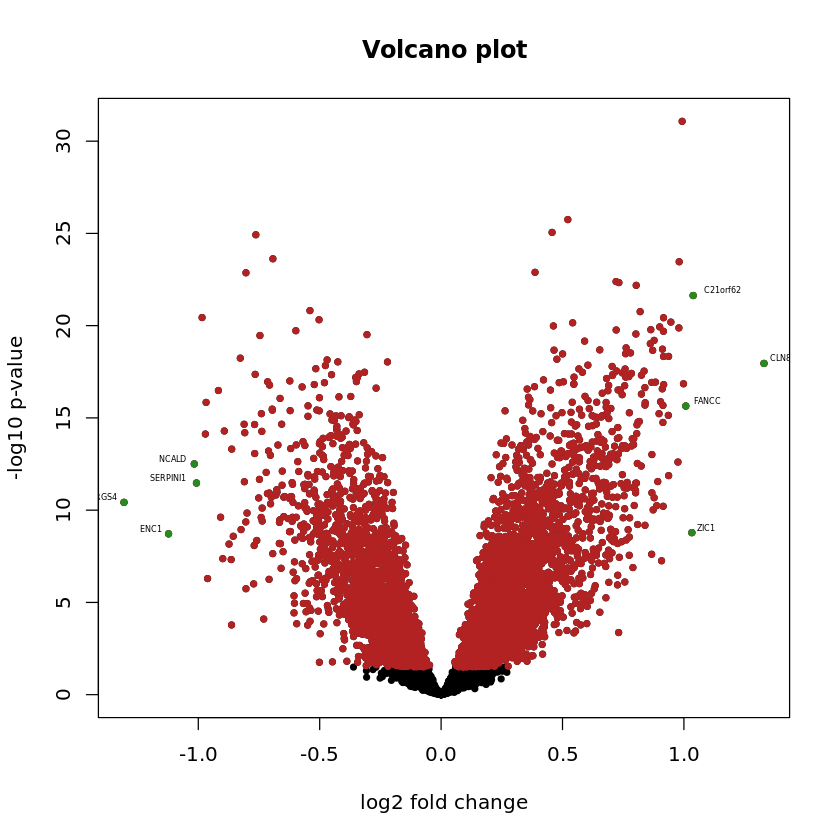

In [41]:
# volcano plot
with(alltable.annot, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", ylab="-log10 p-value", xlab="log2 fold change"))

# Add colored points: red if padj<0.05, orange of log2FC>1, green if both)
with(subset(alltable.annot, adj.P.Val<.05 ), points(logFC, -log10(P.Value), pch=20, col="firebrick"))
with(subset(alltable.annot, abs(logFC)>1), points(logFC, -log10(P.Value), pch=20, col="darkorange4"))
set<-subset(alltable.annot, adj.P.Val<.05 & abs(logFC)>1)
with(set, points(logFC, -log10(P.Value), pch=20, col="forestgreen"))

# Label points with the textxy function from the calibrate plot
#library(calibrate)
with(set, textxy(logFC, -log10(P.Value), labs=rownames(set), cex=.4))
# if I use as labels rownames(alltable.annot) it is ilegible

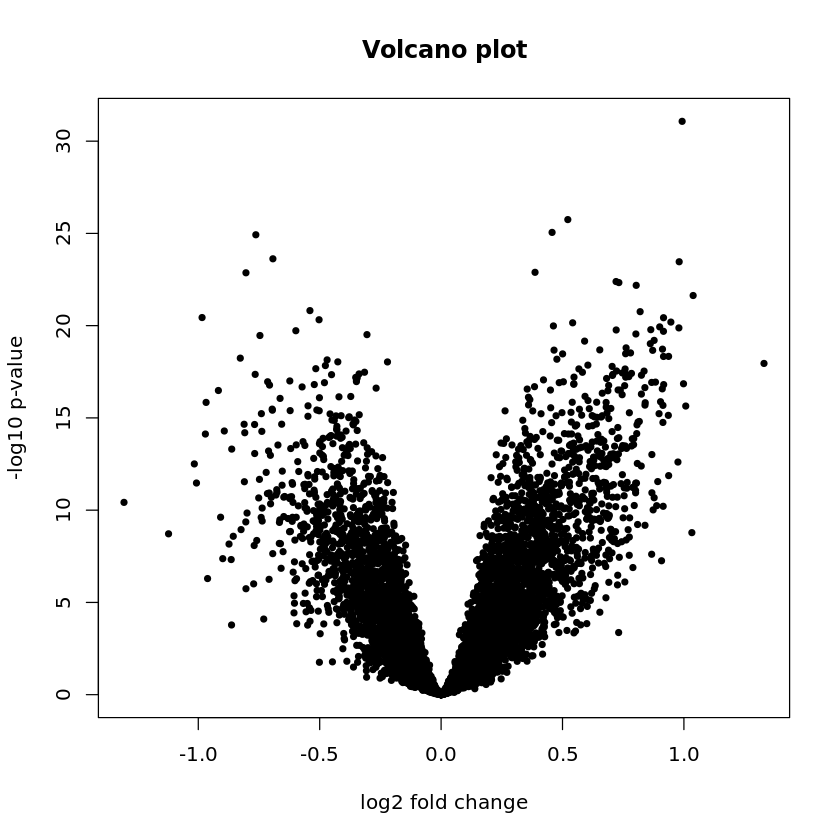

In [65]:
p<-plot(alltable.annot$logFC, -log10(alltable.annot$P.Value), pch=20, main="Volcano plot", ylab="-log10 p-value", xlab="log2 fold change")


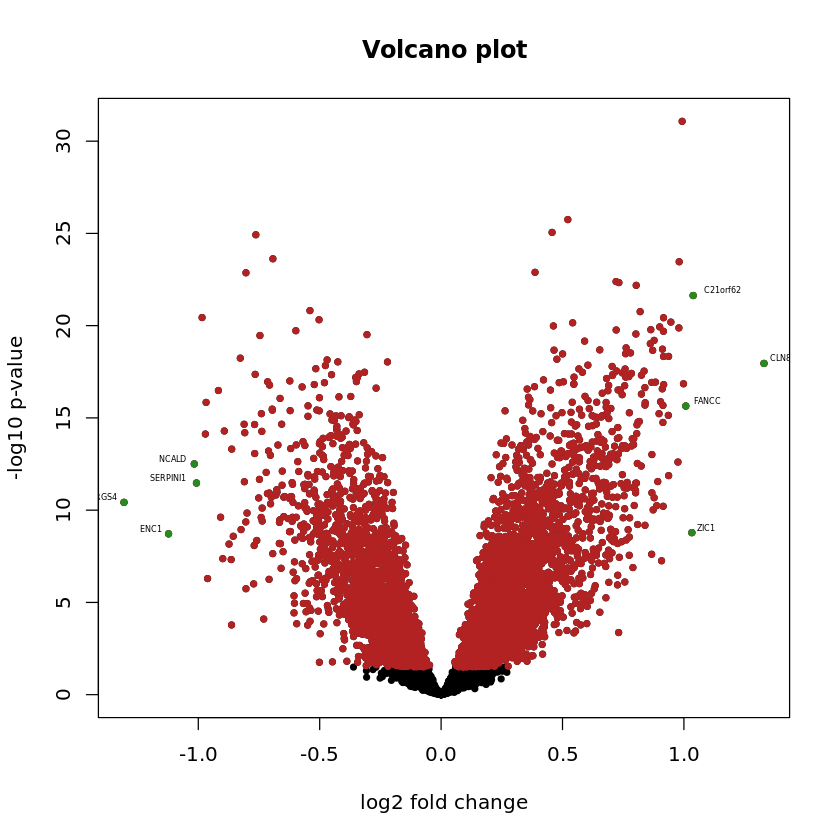

In [63]:
# volcano plot
p<-with(alltable.annot, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", ylab="-log10 p-value", xlab="log2 fold change"))

# Add colored points: red if padj<0.05, orange of log2FC>1, green if both)
p<-with(subset(alltable.annot, adj.P.Val<.05 ), points(logFC, -log10(P.Value), pch=20, col="firebrick"))
p<-with(subset(alltable.annot, abs(logFC)>1), points(logFC, -log10(P.Value), pch=20, col="darkorange4"))
set<-subset(alltable.annot, adj.P.Val<.05 & abs(logFC)>1)
p<-with(set, points(logFC, -log10(P.Value), pch=20, col="forestgreen"))

# Label points with the textxy function from the calibrate plot
#library(calibrate)
p<-with(set, textxy(logFC, -log10(P.Value), labs=rownames(set), cex=.4))
# if I use as labels rownames(alltable.annot) it is ilegible

In [66]:
p

NULL

A **volcano plot** is a type of scatterplot that shows statistical significance (P value) versus magnitude of change (fold change). It enables quick visual identification of genes with large fold changes that are also statistically significant. These may be the most biologically significant genes. In a volcano plot, the most upregulated genes are towards the right, the most downregulated genes are towards the left, and the most statistically significant genes are towards the top.


**Heatmap**

In [43]:
heatmapset<-expr.common[rownames(alltable.cov[1:50 ,]) ,] #top 50 DE probes
head(heatmapset)

,GSM225652__Group3,GSM225662__Group3,GSM225664__Group3,GSM225665__Group3,GSM225666__Group3,GSM225667__Group3,GSM225668__Group3,GSM225670__Group4,GSM225671__Group3,GSM225672__Group3,...,GSM388388__Group4,GSM388389__Group3,GSM388390__Group2,GSM388391__Group4,GSM388392__Group3,GSM388393__Group4,GSM388394__Group4,GSM388395__Group4,GSM388396__Group4,GSM388397__Group4
GI_4585642-S,6.264912,6.887525,5.997744,7.001127,6.366322,6.226894,6.268659,7.374170,6.432959,6.908092,...,6.665336,8.222553,8.647458,6.373300,7.336283,7.912889,7.941341,8.229300,8.820498,8.441699
GI_34577121-S,8.386725,8.789534,8.366759,8.917670,8.150763,8.062316,8.305606,8.420802,8.266318,9.094342,...,8.875903,9.610840,9.462707,8.954196,9.724002,9.050665,9.001127,8.593951,10.040564,9.492654
GI_37547175-S,8.284477,8.284940,8.338068,8.295998,8.627899,8.359750,8.487438,8.526304,8.262565,8.048214,...,8.487840,9.340518,9.056909,8.656425,9.251956,9.271230,8.878051,9.329124,9.317413,9.125672
GI_24308166-S,9.935607,9.525912,11.142681,9.902224,10.563673,10.724002,10.408860,10.114003,10.576862,9.294391,...,9.642774,9.093286,9.288174,9.624247,7.997179,9.599913,8.914684,9.698010,9.047397,8.965207
GI_13376557-S,5.817623,5.921246,5.504620,7.142618,5.733354,6.292782,4.842979,5.916477,6.323730,6.593951,...,7.751544,8.084808,7.179909,7.343408,8.764872,6.794416,7.338959,6.953032,8.663914,8.547280
GI_27734844-S,8.719047,8.348286,8.729961,8.725196,8.531771,8.489045,8.709773,8.444187,8.608440,7.981282,...,7.078951,7.731998,6.599913,7.072535,6.776104,7.549977,7.898450,7.785289,6.977280,7.375039


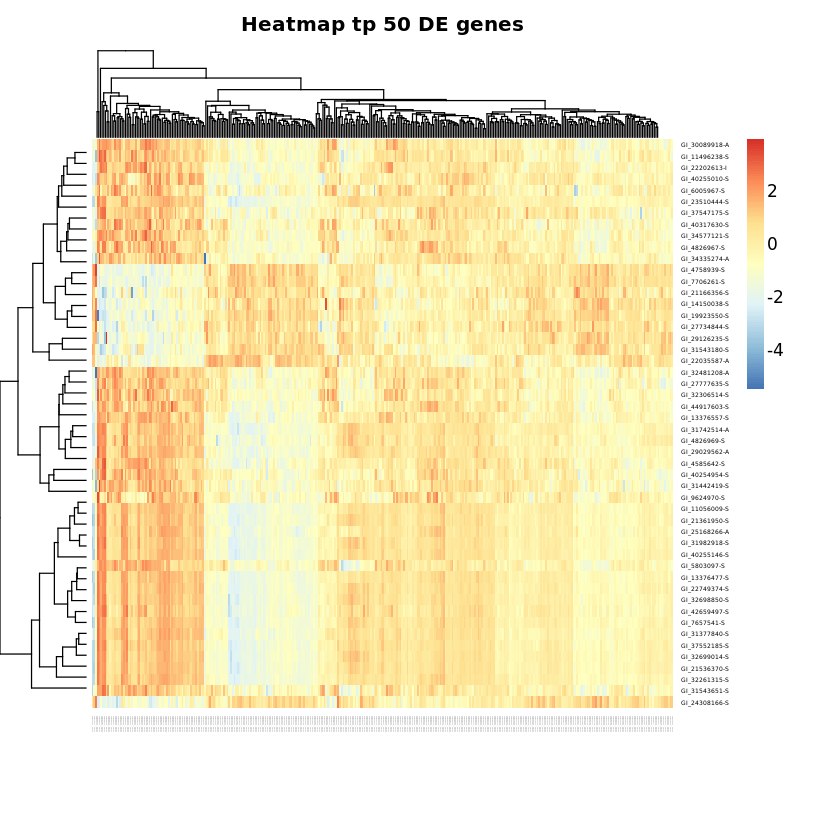

In [44]:
#library(NMF)
h=NMF::aheatmap(as.matrix(heatmapset),Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",main="Heatmap tp 50 DE genes")
#h=aheatmap(as.matrix(heatmapset),Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",main="Heatmap tp 50 DE genes")

In heatmaps the data is displayed in a grid where each row represents a gene and each column represents a sample. The colour and intensity of the boxes is used to represent changes (not absolute values) of gene expression. 

**You can inspect further the histogram using the row and column dendograms.**

In [47]:
h

$Rowv
'dendrogram' with 2 branches and 50 members total, at height 45.50401 

$rowInd
 [1]  4 45 26 46 43 37 12 19 47 39 41 13 36 35 48 21 31 24 14 17 34  1 42 49 29
[26]  5  7 11 22 44 18 33 30  6 16 28 32  9 20 15 38  2 23  3 25 27 10 40 50  8

$Colv
'dendrogram' with 2 branches and 336 members total, at height 14.24671 

$colInd
  [1] 122  15  82 209 212 188 216 223 292 281 186 211 310 325 185 199 267  46
 [19] 222 191 259 143 144 252 329 297 190 189 336 291 335 284 238 331 196 228
 [37] 204 294 250 316 328 227 178 230 271 182 180 215 334 119 326  14 269 233
 [55] 254 242 321 302 315 270 183 241 265 239 240  26 137 136   3 206  51 118
 [73]  30 101  31 115 225  95 120 124 177 150 165  34  20  13  45  19  42  25
 [91]  40  93  64 128  47 117  48  54 280 219 273 309  85   7 266  69  49 104
[109] 125 130 126 129 245  91 102  94 161 287  35  63  80 132  65 116  22  53
[127]  86 138  16 133   1 253 146 147 145 327 105  57 299 320 283 285  50  96
[145] 110  89 151 272  52 162 156 107 108 

**a todos le asigna el mismo cluster...**

In [59]:
col.clusters = as.hclust( h$Colv )
cutree(col.clusters,k=3) # break into k=3 clusters

GSM225652__Group3 GSM225662__Group3 GSM225664__Group3 GSM225665__Group3 
                1                 1                 1                 1 
GSM225666__Group3 GSM225667__Group3 GSM225668__Group3 GSM225670__Group4 
                1                 1                 1                 1 
GSM225671__Group3 GSM225672__Group3 GSM225673__Group2 GSM225674__Group3 
                1                 1                 1                 1 
GSM225675__Group4 GSM225676__Group3 GSM225677__Group4 GSM225678__Group3 
                1                 1                 2                 1 
GSM225679__Group3 GSM225680__Group4 GSM225681__Group3 GSM225682__Group3 
                1                 1                 1                 1 
GSM225683__Group2 GSM225684__Group3 GSM225685__Group2 GSM225686__Group2 
                1                 1                 1                 1 
GSM225687__Group3 GSM225690__Group4 GSM225691__Group3 GSM225692__Group4 
                1                 1                 1                 1 
GSM225693__Group3 GSM225695__Group3 GSM225696__Group4 GSM225698__Group3 
                1                 1                 1                 1 
GSM225699__Group3 GSM225700__Group3 GSM225701__Group4 GSM225702__Group4 
                1                 1                 1                 1 
GSM225703__Group3 GSM225704__Group3 GSM225705__Group3 GSM225706__Group3 
                1                 1                 1                 1 
GSM225707__Group3 GSM225708__Group3 GSM225711__Group3 GSM225713__Group4 
                1                 1                 1                 1 
GSM225714__Group3 GSM225715__Group3 GSM225717__Group3 GSM225718__Group3 
                1                 1                 1                 1 
GSM225719__Group2 GSM225720__Group3 GSM225721__Group3 GSM225722__Group2 
                1                 1                 1                 1 
GSM225723__Group3 GSM225724__Group3 GSM225725__Group3 GSM225726__Group3 
                1                 1                 1                 1 
GSM225727__Group3 GSM225728__Group3 GSM225729__Group4 GSM225730__Group2 
                1                 1                 1                 1 
GSM225731__Group3 GSM225733__Group3 GSM225734__Group3 GSM225735__Group3 
                1                 1                 1                 1 
GSM225736__Group2 GSM225737__Group3 GSM225739__Group4 GSM225741__Group3 
                1                 1                 1                 1 
GSM225742__Group3 GSM225743__Group3 GSM225744__Group3 GSM225745__Group2 
                1                 1                 1                 1 
GSM225746__Group3 GSM225747__Group2 GSM225748__Group2 GSM225749__Group3 
                1                 1                 1                 1 
GSM225751__Group3 GSM225752__Group4 GSM225753__Group3 GSM225754__Group3 
                1                 1                 1                 1 
GSM225756__Group3 GSM225757__Group2 GSM225758__Group3 GSM225759__Group2 
                1                 3                 1                 1 
GSM225760__Group4 GSM225761__Group3 GSM225762__Group3 GSM225763__Group3 
                1                 1                 1                 1 
GSM225764__Group3 GSM225915__Group4 GSM225916__Group3 GSM225918__Group4 
                1                 1                 1                 1 
GSM225919__Group4 GSM225920__Group3 GSM225921__Group3 GSM225922__Group3 
                1                 1                 1                 1 
GSM225923__Group4 GSM225924__Group4 GSM225925__Group3 GSM225926__Group4 
                1                 1                 1                 1 
GSM225927__Group3 GSM225928__Group3 GSM225929__Group3 GSM225930__Group3 
                1                 1                 1                 1 
GSM225931__Group3 GSM225932__Group3 GSM225933__Group3 GSM225934__Group3 
                1                 1                 1                 1 
GSM225935__Group3 GSM225936__Group3 GSM225937__Group4 GSM2

In [57]:
class(cutree(col.clusters,k=3))

[1] "integer"

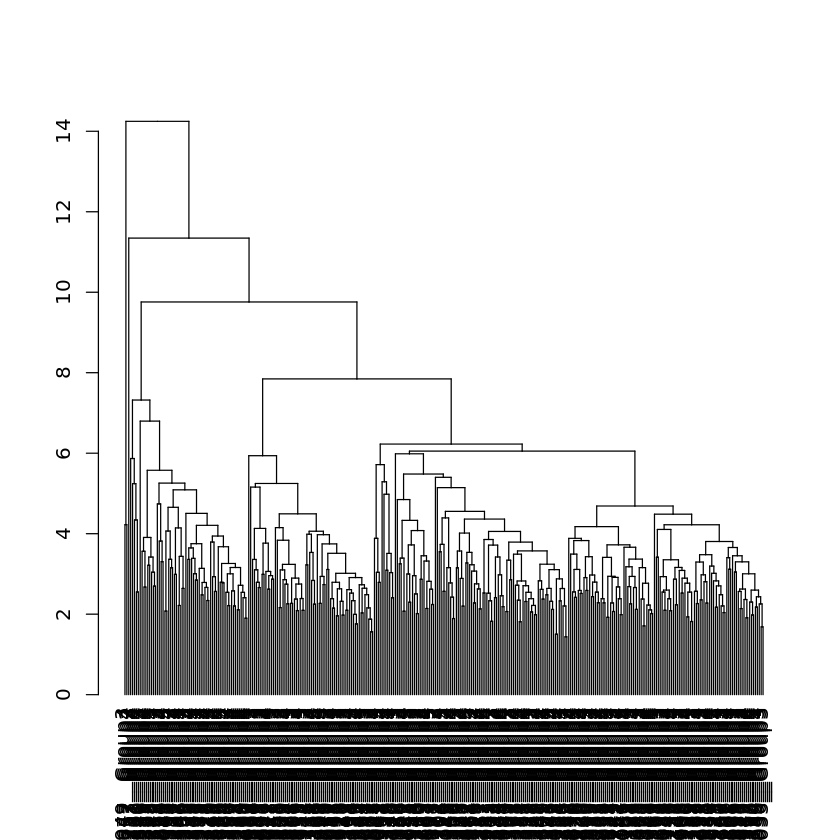

In [54]:
plot(h$Colv)